# Setup

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'w'
import seaborn as sns

# Model formulation

#### Old model structure:

$$
\begin{align}
x_n &\sim \mathcal{N}(\theta_l, \sigma^2) \text{ for } n=1,...,N \\
\theta_l &\sim \mathcal{N}(\mu, \tau^2) \text{ for } l=1,...,L\\
\sigma^2 &\sim Inv.-Gamma(\alpha_s, \beta_s)\\
\mu &\sim \mathcal{N}(\mu_0, \tau_0)\\
\tau^2 &\sim Inv.-Gamma(\alpha_t, \beta_t)\\
\end{align}
$$

#### New model structure:

$$
\begin{align}
x_n &\sim \mathcal{N}(\theta_l, \sigma^2) \text{ for } n=1,...,N \\
\theta_l &\sim \mathcal{N}(\mu, \tau^2) \text{ for } l=1,...,L\\
\sigma^2 &\sim \mathcal{HN}(\sigma_s)\\
\mu &\sim \mathcal{N}(\mu_0, \tau_0)\\
\tau^2 &\sim \mathcal{HN}(\sigma_t)\\
\end{align}
$$

#### Models to be compared

$$
\begin{align}
&\text{Null Model }M_0 \text{: } \mu=0\\
&\text{Alternative Model }M_1 \text{: } \mu \text{ allowed to differ from 0} \\
\end{align}
$$

# Simulator

### Old simulator

In [2]:
def old_simulator(batch_size, n_clusters, n_obs, mu0=0, tau20=1, alpha_t=1, beta_t=1, alpha_s=1, beta_s=1):

    # generate sampling list of model indeces
    model_indices = np.random.choice(2, size=batch_size, p=[0.5, 0.5])
    
    Tau2 = []
    Theta = []
    X = []
    
    for b in range(batch_size):
        if model_indices[b] == 0: 
            mu = 0 
        if model_indices[b] == 1:
            mu = np.random.normal(loc=mu0, scale=np.sqrt(tau20))
        
        # draw from prior
        tau2 = 1/np.random.gamma(alpha_t, beta_t)
        sigma2 = 1/np.random.gamma(alpha_s, beta_s)
        theta = np.random.normal(loc=mu, scale=np.sqrt(tau2), size=n_clusters)
        
        # generate from likelihood
        x = np.random.normal(loc=theta, scale=sigma2, size=(n_obs, theta.shape[0])).T
        
        Tau2.append(tau2)
        Theta.append(theta)
        X.append(x)
            
    return {'Tau2': Tau2, 'Theta': np.array(Theta), 'X': np.array(X)}

### New simulator

In [3]:
def new_simulator(batch_size, n_clusters, n_obs, mu0=0, tau20=1, sigma_t=1, sigma_s=1):

    # generate sampling list of model indeces
    model_indices = np.random.choice(2, size=batch_size, p=[0.5, 0.5])
    
    Tau2 = []
    Theta = []
    X = []
    
    for b in range(batch_size):
        if model_indices[b] == 0: 
            mu = 0 
        if model_indices[b] == 1:
            mu = np.random.normal(loc=mu0, scale=np.sqrt(tau20))
        
        # draw from prior
        tau2 = stats.halfnorm.rvs(scale=sigma_t)
        sigma2 = stats.halfnorm.rvs(scale=sigma_s)
        theta = np.random.normal(loc=mu, scale=np.sqrt(tau2), size=n_clusters)
        
        # generate from likelihood
        x = np.random.normal(loc=theta, scale=sigma2, size=(n_obs, theta.shape[0])).T
        
        Tau2.append(tau2)
        Theta.append(theta)
        X.append(x)
            
    return {'Tau2': Tau2, 'Theta': np.array(Theta), 'X': np.array(X)}

# Prior Predictive Checks

In [4]:
# generate data
sims_old = old_simulator(batch_size=100, n_clusters=50, n_obs=50)
sims_new = new_simulator(batch_size=100, n_clusters=50, n_obs=50)

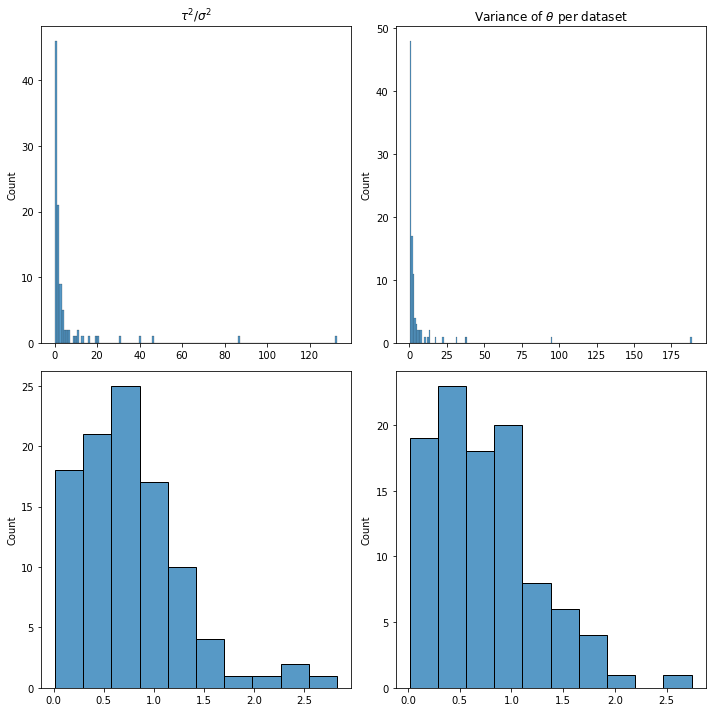

In [5]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 10))

sns.histplot(sims_old['Tau2'], ax = axarr[0,0])
sns.histplot(sims_new['Tau2'], ax = axarr[1,0])
axarr[0,0].set_title(r'$\tau^2$/$\sigma^2$')

sns.histplot(np.var(sims_old['Theta'], axis=1), ax = axarr[0,1])
sns.histplot(np.var(sims_new['Theta'], axis=1), ax = axarr[1,1])
axarr[0,1].set_title(r'Variance of $\theta$ per dataset')

fig.tight_layout()

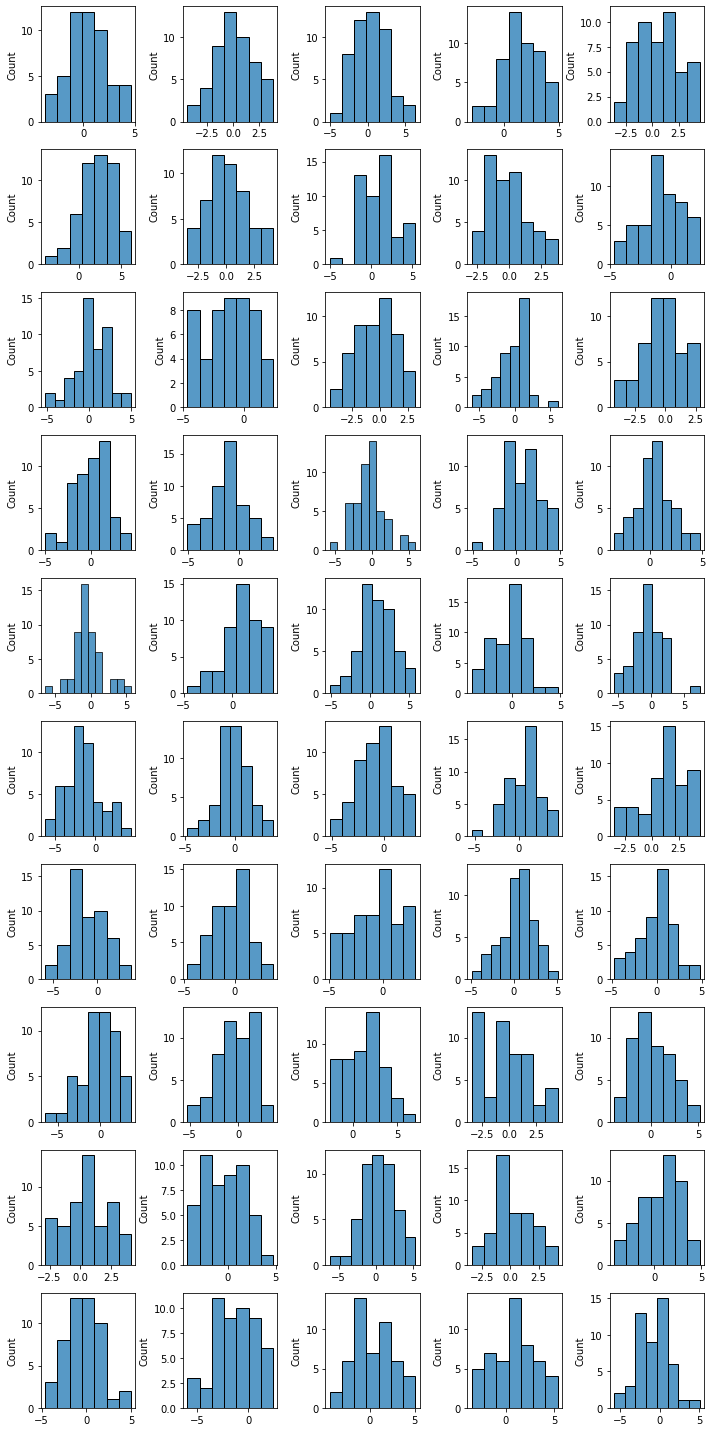

In [6]:
fig, axarr = plt.subplots(10, 5, figsize=(10, 20))

for i in range(50):
    sns.histplot(sims_old['X'][0][i], ax = axarr.flat[i])

fig.tight_layout()

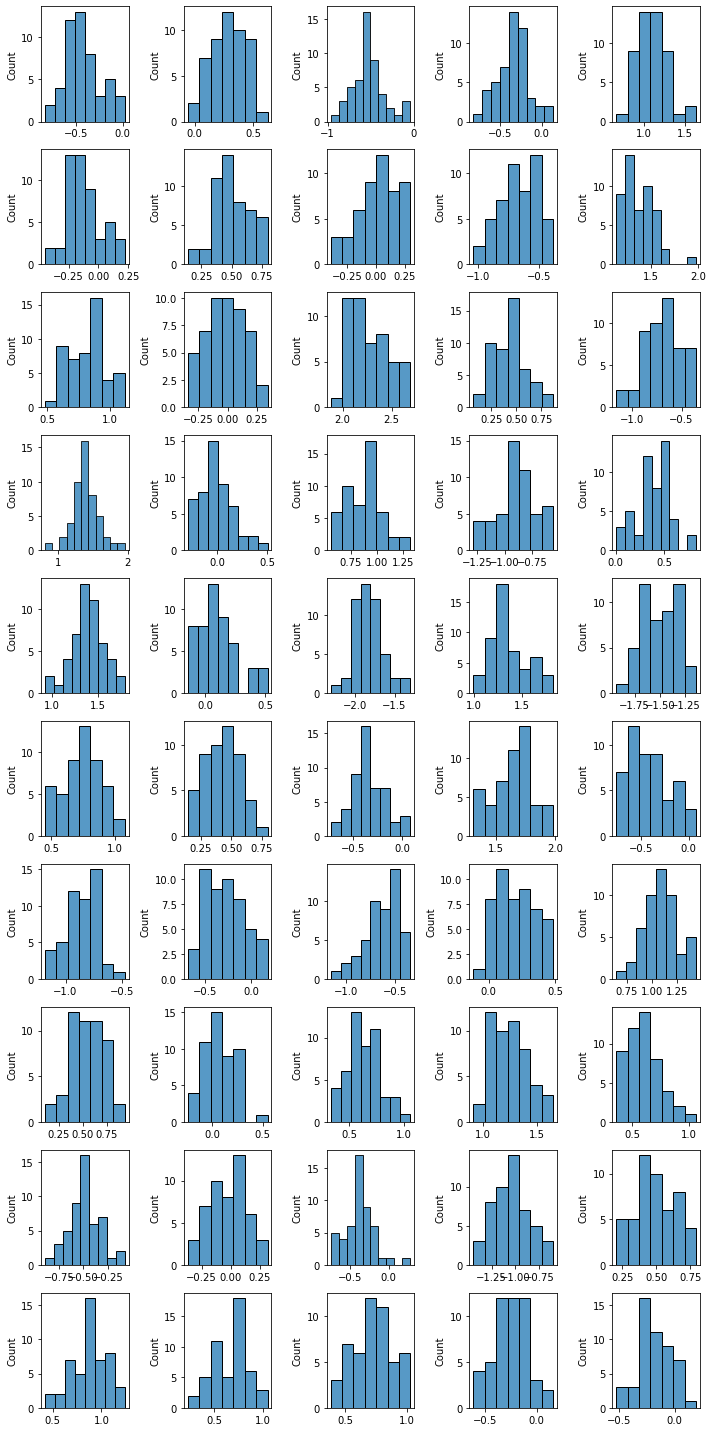

In [7]:
fig, axarr = plt.subplots(10, 5, figsize=(10, 20))

for i in range(50):
    sns.histplot(sims_new['X'][0][i], ax = axarr.flat[i])

fig.tight_layout()